# Approximate Bayes Computation
Thanks: [this video](https://www.youtube.com/watch?v=3OJEae7Qb_o). I am trying to briefly explain the content of it. If you do not get my explanation, you need to watch it. But there is no need to if everything among of what I say below is clear.

### Introduction
Let's say, you did a survey and got some probability. As the video says, you did a salmon survey and found out that 6/16 people subscribed to the weekly salmon shipment. That probability will work out for you just fine if you are a frequentist statistician. Just plague the value into your model and that should do the deal. But we, as the worshippers of Lord Bayes, will not go that way. Let's generate a dataset using this tool for our calculations.

But why don't we just use the probability as it is? Because sometimes we need to consider multiple probabilities being possible and how they are going to affect our predictions. 6 / 16 doesn't tell you much. This result can be produced by any probability, let's assume it being equal to 0.1 and it just so happened that 6 / 16 of our clients bought our product. Definitely, you can get more precise probability by asking more and more possible clients but it is not always the case. What you might want instead is to have multiple `probabilities of customer's choice` and see how many of this probabilities are giving the result you got in the survey.

- There is a small chance that  customer's choice is very low and your company will become insolvent
- There also is a small chance that you the idea of salmon shipment is brilliant and worth trillion dollars of income

But, what you might really be interested in are small variations in the customer's choice probability and how they are going to affect your incomes. This will be ideal for comparisons between advertising with different cost and survey probabilities:

- Salmon brochure costs 2$ and the signup rate is 6/16

- Salmon brochure + a salmon sample costs 27$ and the signup rate is 10/16

Which advertisement politics should your company choose?

![It is going to be a normal distro](../res/normal_distribution.png)

### Simple example
Let's say you have the `probability of customer's choice` being randomly picked and equal to 0.32. The survey probability is the same (equal to 6/16). And now, let's compel our virtual customer to choose 16 times. If he answered `yes` 6 times and 10 `no`s, we add this probability to some specific array that is storing the probabilities that are producing results close to what the survey probability has produced. And we do so (say) 10000 times. What have we got at the and? We'll have an array of probabilities that produced our survey result.

Fun fact: this array will be a normal distribution with the **maximum likelihood** (treat it as 'the peak at') `ground truth probability of client's choice` because there will be more probabilities close to it. (I know, it is not so clear as for now)

### How it works
First, we need to know what Approximate Bayes Computation consists of:
- Data
- A generative model
- Priors

We already have the data (being the probability we calculated, in our case)

**Generative model** is going to create our new probabilities 'dataset' based on the **prior** probability we feed it. Virtual customer deciding whether to subscribe.

**Priors** is the thing that is going to tell our model how to generate our data.
The array of random probabilities (`probability of customer's choice`) we are to feeding our model.

**Posteriors** is the new 'dataset' of probabilities we generated.

Let's define our priors. We want the chances to be truly random so we are going to use a uniform distribution that is going provide us with a set of some random values we will feed to our model. In other words, we are going to consider all probabilities equally likely to be chosen.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline

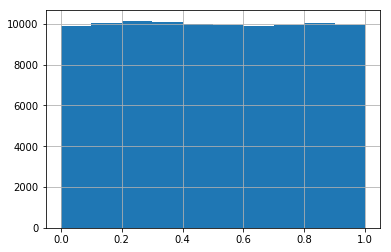

In [2]:
n_draws = 100000

prior = pd.Series(np.random.uniform(0, 1, size=n_draws))
prior.hist()

**np.random.binomial** is our virtual virtual customer. It returns the value of `yes` chosen.

16 is the value it chooses from, p is the **prior** probability 

In [3]:
def generative_model(p):
    return np.random.binomial(16, p)

Now lets make our customer guess 100000 times with equal chances to choose any probability

In [4]:
sim_data = [generative_model(p) for p in prior]

We need to select only those probabilities from posterior that generated us 6 (the value we got in the survey, out of 16 customer choices)

In [5]:
posterior = prior[list(map(lambda x: x == 6, sim_data))]

Let's see how it looks like:

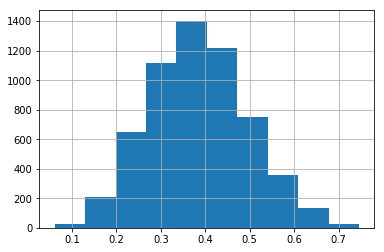

In [6]:
posterior.hist()

Nice normal distribution, as I said. And the 'pinnacle' is roughly the ground truth `customer's choice probability`

### Comparing the probabilities

Now that we calculated our client's probability distribution, and were about to go home, we stumbled upon our CEO. And the CEO suggested us to calculate probabilities for his new advertising company that involved sending a salmon sample to our possible customers. The results just came and the survey probability of customer choice is 10/16. Let's return to our office and use the code we've already written

But we also want to have posterior probability. We already have a graph(hist): n_counts: client probabilities. We want to have probabilities instead of n_counts. You can achieve it using z-scores as i described earlier, but there is a faster method:

$${ f_{X\mid Y=y}(x)={f_{X}(x)L_{X\mid Y=y}(x) \over {\int _{-\infty }^{\infty }f_{X}(u)L_{X\mid Y=y}(u)\,du}}}$$

- $f_{X\mid Y=y}(x)$ -  is the posterior density of $X$ given the data $Y=y$. This is what we are looking for
- $f_{X}(x)$ is the prior density of $X$. We often know what kind of distribution we use as the prior (uniform, in our case), so it can be calculated using the formulas
- $L_{X\mid Y=y}(x)$ is the likelihood function of $x$ given the data $Y=y$. 
- ${\displaystyle \int _{-\infty }^{\infty }f_{X}(u)L_{X\mid Y=y}(u)\,du}$ is the normalizing constant.

And that's hell a lot of to understand. But we have a simpler way to think about it

Let's just measure the likelihood using Bernoulli formula

${\displaystyle P_{k,n}=C_{n}^{k}p^{k}q^{n-k}=C_{n}^{k}p^{k}(1-p)^{n-k}}.$

In [15]:
# Some boilerplate for our calculations
import math
from scipy import stats
from scipy.special import factorial
from matplotlib import pyplot as plt

def likelihood(theta, n, x):
    return (factorial(n) / (factorial(x) * factorial(n - x))) * (theta ** x) * ((1 - theta) ** (n - x))

def pprob(prior, posterior, n_occured, n_events):
    return pd.Series(map(lambda theta: likelihood(theta, n_events, n_occured), prior))
    
def generative_model(n_events, p):
    return np.random.binomial(n_events, p)

def ABC(n_occured, n_events, n_draws=10000):
    prior = pd.Series(sorted(np.random.uniform(0, 1, size=n_draws)))
    sim_data = [generative_model(n_events ,p) for p in prior]
    posterior = prior[list(map(lambda x: x == n_occured, sim_data))]
    posterior_probability = pprob(prior, posterior, n_occured, n_events)
    
    # let's see what we got
    return prior, posterior, posterior_probability

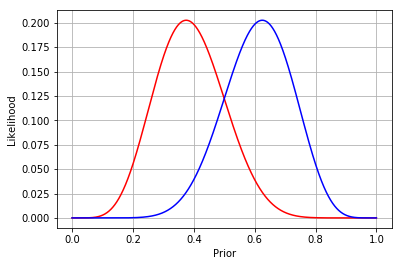

In [16]:
priorA, posteriorA, pprobA = ABC(6, 16)
priorB, posteriorB, pprobB = ABC(10, 16)
f, ax = plt.subplots(1)
ax.plot(priorA, pprobA, 'r', priorB, pprobB, 'b')
ax.set_xlabel("Prior")
ax.set_ylabel("Likelihood")
ax.grid()
plt.show()

Now let's compare them

In [18]:
dPprob = (pprobA * 1000 - 30) - (pprobB * 1000 - 30)
print('Method a is better in', sum(dPprob > 0)/sum(dPprob), 'cases')

Method a is better in 0.6374820149273815 cases


That's it for Bayesian inference. That technique can be used with basically any ML algorithm including Naive Bayes, Deep Learning, SVM, Gradient Boosting and so on. But there is something wrong with our inference implementation. It is extremely slow because it is processing all the data we have. In the next tutorial, I will introduce some MCMC methods that are able to increase the performance significantly